# Overview of pipeline

1. Read questionnaire data from csv file (all answers in a single corpus)
2. EDA: Distribution of characters
3. Text preprocessing and cleaning (output = clean corpus)
4. EDA: Distribution of document length
5. EDA: Distribution of word frequencies (detection of hapaxes ...)
6. EDA: Collocation detection (bigrams and trigrams) TO DO: detected collocations should be
treated as tokens in BOW.
7. Text representation with BOW (output = vocabulary list and DTM)
8. Summarization of each question separately:
a) Topic words + Sumbasic method; b) Probabilistic Topic Modeling-based method (LDA); c) Clustering-based method.

**Main reference about summarization methods**

"Text Summarization Techniques: A Brief Survey", by M. Allahyari et al, 2017.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14

In [3]:
np.set_printoptions(precision=3)

In [4]:
import seaborn as sns

In [5]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [6]:
from collections import defaultdict

In [7]:
from nltk.tokenize import sent_tokenize

In [8]:
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

In [ ]:
import colorama
from colorama import Fore, Style

In [9]:
print(Fore.BLUE + "Hello World")

Hello World


In [10]:
print(Fore.RED + "Hello World")

Hello World


## Read questionnaire data

In [11]:
# Read data from a CSV file : this will return a DataFrame object
data_df = pd.read_csv("../data/QUESTIONNAIRE DATA/QuestionnaireData_28Nov2018.csv",encoding='ansi')

In [12]:
data_df.shape

(268, 14)

In [13]:
data_df.head()

,Votre âge,Sexe,Etat civil,Niveau d'étude,Etablissement d'études,Situation professionnelle,Région,Domaine d'études,Q1 : Qu'est-ce qui vous ferait rester en Tunisie ?,Q2 : Quel salaire vous fera rester en Tunisie ?,Q3 : Qu'est-ce qui encouragerait les étrangers à venir en Tunisie ?,Q4 : Qu'est-ce qui vous ferait partir à l'étranger ?,Q5 : Quelle est la différence au point de vue social entre la Tunisie et l'étranger ?,Q6 : Quelle est la différence au point de vue professionnel entre la Tunisie et l'étranger ?
0,20-25,Femme,Célibataire,Ingénieur,INSAT,Etudiant,Grand Tunis,Sciences de l'Ingénieur,"mes études, ma famille et mon entourage",2000,le tourisme,la volonté de faire de l’expérience et de fair...,A l'étranger on trouve plus de respect.,A l'étranger ils payent plus et ils sont plus ...
1,20-25,Homme,Célibataire,Ingénieur,ENIT,Etudiant,Grand Tunis,Sciences de l'Ingénieur,Rien,2000,Réputation,Niveau de conscience populaire,La valeur d homme,Recherche
2,26-30,Femme,Célibataire,Mastère,ESAD,Fonctionnaire,Grand Tunis,Artistique,La mentalité,2000 dinars,la sécurité,l'argent,la tolérance,la motivation
3,31 et plus,Homme,Marié,Licence,FST,Fonctionnaire,Grand Tunis,Sciences de l'Ingénieur,Qualité de vie,3500,"Pour un investisseur, la rémunération des empl...",L'expérience + le salaire,La mentalité sur le niveau professionnel et so...,"À l'étranger, les expériences sont plus intere..."
4,20-25,Femme,Célibataire,Mastère,Faculté des Sciences Humaines et Sociales de T...,Fonctionnaire,Grand Tunis,Sciences humaines et sociales,Une bonne ambiance de travail,2000 dinars,"Les bonnes conditions climatiques, la convivia...",Des fourchettes salariales plus importantes et...,Une meilleure parité en matière de compétence,"T es payé pour ta compétence, les plafonds de ..."


In [14]:
pd.Series(data_df.columns)

0                                             Votre âge
1                                                  Sexe
2                                            Etat civil
3                                        Niveau d'étude
4                                Etablissement d'études
5                             Situation professionnelle
6                                                Région
7                                      Domaine d'études
8     Q1 : Qu'est-ce qui vous ferait rester en Tunis...
9       Q2 : Quel salaire vous fera rester en Tunisie ?
10    Q3 : Qu'est-ce qui encouragerait les étrangers...
11    Q4 : Qu'est-ce qui vous ferait partir à l'étra...
12    Q5 : Quelle est la différence au point de vue ...
13    Q6 : Quelle est la différence au point de vue ...
dtype: object

In [15]:
corpus_docs = []
corpus_labels = []
n = len(data_df)
for i in range(8,14):
    if i != 9:
        corpus_docs = corpus_docs + data_df.iloc[:,i].tolist()
        corpus_labels = corpus_labels + [(i-7)]*n

In [16]:
assert(len(corpus_docs) == 5*n and len(corpus_labels) == len(corpus_docs))

In [17]:
n,len(corpus_docs)

(268, 1340)

In [18]:
corpus_labels[0:5],corpus_docs[0:5]

([1, 1, 1, 1, 1],
 ['mes études, ma famille et mon entourage',
  'Rien',
  'La mentalité',
  'Qualité de vie',
  'Une bonne ambiance de travail '])

In [19]:
corpus_df = pd.DataFrame({'document':corpus_docs,'qlabel':corpus_labels})

In [20]:
corpus_df.head()

,document,qlabel
0,"mes études, ma famille et mon entourage",1
1,Rien,1
2,La mentalité,1
3,Qualité de vie,1
4,Une bonne ambiance de travail,1


In [21]:
corpus_df.qlabel.value_counts()

6    268
5    268
4    268
3    268
1    268
Name: qlabel, dtype: int64

*******

## Exploratory Analysis of Distribution of Characters
EDA of characters before preprocessing.

In [22]:
# temporary variable
corpus_ = corpus_df.document

In [23]:
corpus_chars_list = "\n".join(corpus_)
print(type(corpus_chars_list),len(corpus_chars_list))

<class 'str'> 66351


In [24]:
fdist1 = FreqDist([c for c in corpus_chars_list])

In [25]:
print("number of characters:" + str(fdist1.N()))
print("number of unique characters:" + str(fdist1.B()))

number of characters:66351
number of unique characters:96


In [26]:
u = list(fdist1.keys())
u.sort()
print('List of unique characters in the corpus:')
print(u)

List of unique characters in the corpus:
['\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '9', ':', ';', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Ç', 'É', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '’', '€']


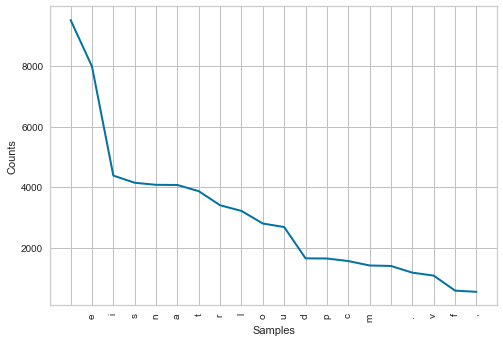

In [27]:
fdist1.plot(20, cumulative=False)

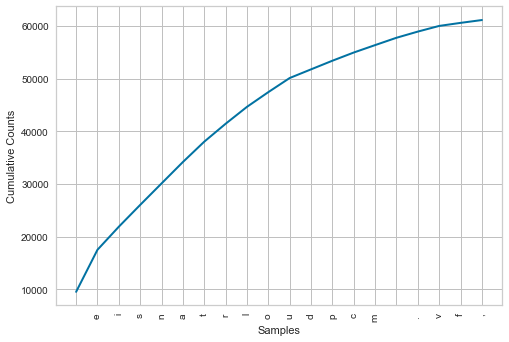

In [28]:
# the top 20 characters cover more than 95% of all character occurrences in the corpus
fdist1.plot(20,cumulative=True)

In [29]:
# the 10 most frequent characters in the corpus
#pd.DataFrame(fdist1.most_common(20))
fdist1.most_common(5)

[(' ', 9522), ('e', 7990), ('i', 4381), ('s', 4144), ('n', 4076)]

*Observations & conclusions*
- Type of characters: french letters, digits, punctuation, and white space.
- No special characters requiring special normalization/preprocessing (such as special encoded characters).
- No extraneous/noisy characters that should be removed prior to language identification (such as math symbols, emoticons and urls).

*****

## Text Preprocessing & Cleaning

Pipeline:
1. Language identification
2. Sentence segmentation
3. Remove non-word characters
4. Convert to lowercase
5. Tokenization
6. Stemming (simple heuristic for word normalization)
7. Spelling correction

### Language identification
TO DO: use `langid` or ``lagdetect`` modules (rather than `TextCat` which is too slow!)

In [30]:
# Load library module for language identification
# from nltk.classify.textcat import TextCat

In [31]:
# Remove non-french documents from corpus_df
# corpus_df = ...

### Sentence segmentation
Split the documents into sentences.

#### EDA

In [32]:
for c in ['.','!','?']:
    print(c,fdist1[c])

. 402
! 30
? 5


In [33]:
L1 = [len(doc) for doc in corpus_df.document]
L2 = [len(sent_tokenize(doc)) for doc in corpus_df.document]
doc_len_df_ = pd.DataFrame({'n_chars' : L1, 'n_sents' : L2, \
                            'n_chars_per_sent' : np.array(L1)/np.array(L2)})
doc_len_df_.head()

,n_chars,n_chars_per_sent,n_sents
0,39,39.0,1
1,4,4.0,1
2,12,12.0,1
3,14,14.0,1
4,30,30.0,1


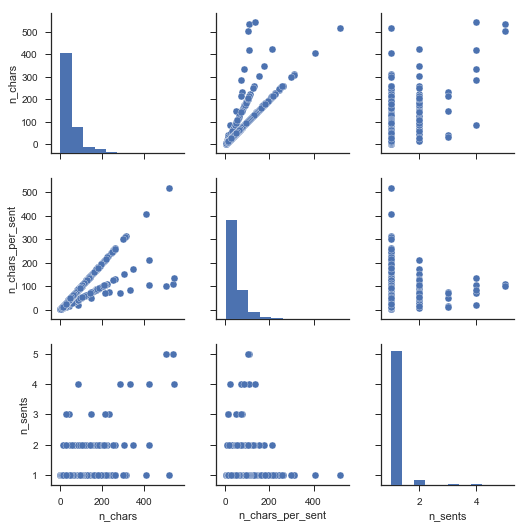

In [34]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(doc_len_df_)

#### Create corpus of sentences

In [35]:
corpus_sentences_ = [sent_tokenize(doc) for doc in corpus_df.document]
len(corpus_sentences_),corpus_sentences_[0]

(1340, ['mes études, ma famille et mon entourage'])

In [36]:
u = [(sent,corpus_df.qlabel[i]) for i,doc in enumerate(corpus_sentences_) for sent in doc]
corpus_sent_df = pd.DataFrame(u)
corpus_sent_df.columns = ['sentence','qlabel']
assert(len(corpus_df)<=len(corpus_sent_df))
len(corpus_df),len(corpus_sent_df)

(1340, 1418)

In [37]:
corpus_sent_df.head()

,sentence,qlabel
0,"mes études, ma famille et mon entourage",1
1,Rien,1
2,La mentalité,1
3,Qualité de vie,1
4,Une bonne ambiance de travail,1


### Tokenization
- convert to lowercase.
- convert corpus to list of words
- throw away all non-letter characters (in our case digits and punctuation)

In [38]:
tokenizer = RegexpTokenizer('[^_\W0-9]+')

In [39]:
# convert to lowercase and tokenize
corpus_tokens_ = [tokenizer.tokenize(doc.lower()) for doc in corpus_sent_df.sentence]
assert(len(corpus_tokens_)==len(corpus_sent_df))
corpus_tokens_[0:5]

[['mes', 'études', 'ma', 'famille', 'et', 'mon', 'entourage'],
 ['rien'],
 ['la', 'mentalité'],
 ['qualité', 'de', 'vie'],
 ['une', 'bonne', 'ambiance', 'de', 'travail']]

In [40]:
corpus_sent_df['tokenized_sent'] = corpus_tokens_
corpus_sent_df.head()

,sentence,qlabel,tokenized_sent
0,"mes études, ma famille et mon entourage",1,"[mes, études, ma, famille, et, mon, entourage]"
1,Rien,1,[rien]
2,La mentalité,1,"[la, mentalité]"
3,Qualité de vie,1,"[qualité, de, vie]"
4,Une bonne ambiance de travail,1,"[une, bonne, ambiance, de, travail]"


In [41]:
## Which documents are empty?
[corpus_sent_df.sentence[i] for i,doc in enumerate(corpus_tokens_) if len(doc)==0]

['!', '!', '-', '.', '!', '-', '!']

In [42]:
## Word frequency distribution
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist2 = FreqDist(corpus_words_)
fdist2.N(),fdist2.B()

(10904, 1977)

In [43]:
fdist2.most_common(10)

[('de', 579),
 ('la', 425),
 ('et', 379),
 ('le', 356),
 ('l', 322),
 ('les', 274),
 ('un', 173),
 ('des', 167),
 ('plus', 164),
 ('d', 162)]

### Fix common orthographic errors
- 'œ' --> 'oe'

**TO BE FINISHED ...**

In [44]:
# strange characters
#for c in ['ù', 'û', 'ô', 'â', 'î', 'ù', '5', '1', '3']:
#    print(c,fdist1[c])

In [45]:
fdist1['œ'],len('œ')

(3, 1)

In [46]:
fdist1['à'],fdist1['a']

(147, 4070)

In [47]:
fdist2['à'],fdist2['a']

(150, 59)

### Remove stopwords
We will use NLTK's default list of stop worsd for the French language.

#### Load standard list of stop words

In [48]:
# Load NLTK stop words
stop_words_fr = stopwords.words('french')
stop_words_fr = set(stop_words_fr)
len(stop_words_fr)

155

In [49]:
#we can also add an entire list of words
stop_words_fr = stop_words_fr |  {'celle', 'celles', 'certain', 'certains', 'les','ils', 'elles', 'avoir', 'être', 'parce','où','si','chaque','donc','dont','encore','faut','quand','tant','tel','va','ici', 'ça'}
len(stop_words_fr)

178

In [50]:
stop_words_fr = stop_words_fr - {'ne', 'pas'}
len(stop_words_fr)

176

#### EDA - Customize stop words to current corpus

In [51]:
# Visually inspect words that are common in the corpus but are not in our stopwords list
u1 = pd.DataFrame([(word,freq) for word,freq in fdist2.most_common(100) if word not in stop_words_fr])
u1.columns = ['word', 'frequency']
len(u1)

60

In [52]:
u1.sort_values('frequency', ascending=False).head(30)

,word,frequency
0,plus,164
1,travail,156
2,vie,149
3,salaire,124
4,tunisie,114
5,pas,102
6,étranger,102
7,famille,97
8,respect,91
9,niveau,71


In [53]:
## Add those words to our list of stopwords
stop_words_fr = stop_words_fr | {'a'}
len(stop_words_fr)

177

In [54]:
# Visually inspect words that are stopwords and are sufficiently common in this corpus
u2 = pd.DataFrame([(word,fdist2[word]) for word in stop_words_fr if fdist2[word]>=3])
u2.columns = ['word', 'frequency']
len(u2)

74

In [55]:
u2.sort_values('frequency', ascending=False).head(35)

,word,frequency
53,de,579
21,la,425
42,et,379
34,le,356
49,l,322
63,les,274
35,un,173
48,des,167
41,d,162
19,à,150


In [56]:
## No words to remove from stopwords!


#### Remove stopwords from corpus

In [57]:
# Finally remove stop words from our corpus
u = [[word for word in sent if word not in stop_words_fr] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)
corpus_sent_df.head()

,sentence,qlabel,tokenized_sent
0,"mes études, ma famille et mon entourage",1,"[études, famille, entourage]"
1,Rien,1,[rien]
2,La mentalité,1,[mentalité]
3,Qualité de vie,1,"[qualité, vie]"
4,Une bonne ambiance de travail,1,"[bonne, ambiance, travail]"


In [58]:
# Which documents became empty after removing stopwords?
[(i,row.sentence) for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]

[(367, '!'),
 (836, '!'),
 (911, 'A'),
 (922, '-'),
 (1206, '.'),
 (1215, '!'),
 (1219, '-'),
 (1236, '!')]

In [59]:
corpus_sent_df.iloc[390,:]

sentence          1€=3dt
qlabel                 3
tokenized_sent      [dt]
Name: 390, dtype: object

### Clean up words based on word length
- will first get an idea about which words are unusually short or long.
- Very short words are usually not very meaningful; might be stopwords or abbreviations of some sort --> usually should be removed.
- Very long words are rare or meaningless or concatenations of multiple words, elongated words --> usually should be removed or normalized/stemmed.

In [60]:
# create list of all words in corpus
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
type(corpus_words_),len(corpus_words_)

(list, 6145)

In [61]:
word_len_df_ = pd.Series([len(word) for word in corpus_words_],index=corpus_words_)
word_len_df_.head()

études       6
famille      7
entourage    9
rien         4
mentalité    9
dtype: int64

In [62]:
word_len_df_.describe()

count    6145.000000
mean        6.986981
std         2.802266
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        19.000000
dtype: float64

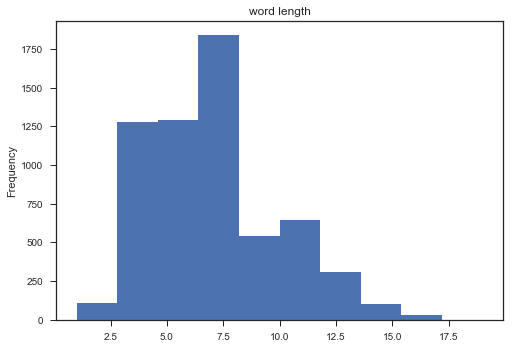

In [63]:
fig = word_len_df_.plot(kind='hist', title="word length")

In [64]:
# words with <= 2 characters
word_len_df_[word_len_df_<=2].value_counts()

2    85
1    24
dtype: int64

In [65]:
word_len_df_[word_len_df_<=2].head()

is    2
i     1
my    2
my    2
up    2
dtype: int64

In [66]:
# Remove words with <= 2 characters
u = [[word for word in sent if len(word)>2] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)
corpus_sent_df.head()

,sentence,qlabel,tokenized_sent
0,"mes études, ma famille et mon entourage",1,"[études, famille, entourage]"
1,Rien,1,[rien]
2,La mentalité,1,[mentalité]
3,Qualité de vie,1,"[qualité, vie]"
4,Une bonne ambiance de travail,1,"[bonne, ambiance, travail]"


In [67]:
# Which documents became empty after removing short words?
[(i,row.sentence) for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]

[(367, '!'),
 (390, '1€=3dt'),
 (836, '!'),
 (911, 'A'),
 (922, '-'),
 (1206, '.'),
 (1215, '!'),
 (1219, '-'),
 (1236, '!')]

In [68]:
## Word frequency distribution
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist3 = FreqDist(corpus_words_)
assert(fdist3.N()<fdist2.N() and fdist3.B()<=fdist3.B())
print(fdist2.N(),fdist2.B())
print(fdist3.N(),fdist3.B())

10904 1977
6036 1843


*Observations & conclusions*
- Most short words are either stopwords or non-french words (english or tunisian dialect).

### Spell Checking of words
Merge (conflate) orthographically similar words.

Algorithm: 
- build undirected graph of words (nodes);
- put edge between words with edit/Levenshtein distance <= Threshold (currently using Threshold = 1); 
- find groups of words as the connected components of this graph.

In [69]:
fdist3['œuvre'],fdist3['oeuvre']

(3, 16)

#### Build graph of orthographically similar words

In [70]:
import networkx as nx

In [71]:
from nltk import edit_distance

In [72]:
#?nx.Graph

In [73]:
#?edit_distance

In [74]:
long_words_ = list({word for sent in corpus_sent_df.tokenized_sent for word in sent if len(word)>=6})
len(long_words_)

1415

In [75]:
#n = len(long_words)
#M = np.zeros((n,n))
#d = defaultdict(list)
g = nx.Graph() # empty UNDIRECTED graph
for i,word1 in enumerate(long_words_):
    for j in range(i+1,len(long_words_)):
        word2 = long_words_[j]
        if abs(len(word1)-len(word2)) <= 1:
            e = edit_distance(word1,word2)
            #M[i,j] = e
            if e == 1:
                g.add_edge(i,j)
                #M[i,j] = 1
                #M[j,i] = 1
                #print(word1,word2)
                #d[word1].append(word2)

#len(d),np.sum(M==1)
#[(k,v) for k,v in d.items() if len(v)>0]
#M2 = np.asmatrix(M)
#sns.heatmap(M2, annot=False)

print(len(g.edges()),len(g.nodes()))   ## g.is_directed(),,g.size()

367 550


#### Find connected components of words
**TO DO**: remove CCs with low cohesion ...

In [76]:
#largest_cc = max(nx.connected_components(g), key=len)
#[long_words_[i] for i in largest_cc]

In [77]:
CCs = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
len(CCs)

217

In [78]:
u = [len(cc) for cc in CCs]
assert(min(u) >= 2)
pd.Series(u).value_counts()

2    161
3     26
4     19
7      3
5      3
9      2
6      2
8      1
dtype: int64

In [79]:
## Visually inspect and validate similar words
[[long_words_[i] for i in cc]  for cc in CCs]

[['différent',
  'difference',
  'différant',
  'différences',
  'différents',
  'différente',
  'different',
  'diffèrent',
  'différence'],
 ['etrangere',
  'étranger',
  'letranger',
  'etrangers',
  'étanger',
  'etranger',
  'entranger',
  'étrangers',
  'etrangeres'],
 ['développe',
  'développera',
  'développées',
  'développer',
  'développé',
  'développés',
  'développée',
  'developper'],
 ['change', 'échange', 'charge', 'charges', 'chance', 'chances', 'changer'],
 ['respecte',
  'respecté',
  'respect',
  'respected',
  'respet',
  'respecter',
  'respcet'],
 ['mentality',
  'mentalité',
  'montalité',
  'mentalit',
  'mortalité',
  'mentalités',
  'mentalite'],
 ['avancés', 'avancé', 'avancer', 'avancéée', 'avance', 'avancée'],
 ['aiment', 'payment', 'paiement', 'paiment', 'payent', 'aident'],
 ['diplome', 'diplomes', 'diplômés', 'diplôme', 'diplômes'],
 ['financière', 'financiers', 'financieres', 'financières', 'financier'],
 ['trouve', 'trouveras', 'trouvera', 'trouvé',

In [80]:
L = ['aident', 'payment', 'paiment', 'aiment', 'paiement', 'payent']
L.sort()

for word1 in L:
    for word2 in L:
        if word1<word2:
            print(word1,word2,edit_distance(word1,word2))

aident aiment 1
aident paiement 3
aident paiment 2
aident payent 3
aident payment 3
aiment paiement 2
aiment paiment 1
aiment payent 3
aiment payment 2
paiement paiment 1
paiement payent 3
paiement payment 2
paiment payent 2
paiment payment 1
payent payment 1


#### Merge (conflate) orthographically similar words in the corpus
Finally, merge similar words. Keep the most frequent word as the group representative.

In [81]:
# Create dictionary of groups of similar/related words
word_map1_dict_ = defaultdict(str)

for cc in CCs:
    #elements of cc are integer indices of words in the long_words_ list
    assert(len(cc) >= 2)
    word_group_ = [long_words_[i] for i in cc]  #group of 2 or more orthographically similar words
    word_freq_ = [fdist3[word] for word in word_group_]  #their frequencies
    word_len_ = [len(word) for word in word_group_]  #their lengths

    ## Select best word in this group
    #new method: select most frequent word; break ties by selecting shorter word
    word_freq_df_ = pd.DataFrame({'freq':word_freq_, 'length': word_len_}, index = word_group_)
    word_freq_df_.sort_values(by=['freq','length'], ascending=[False,True], inplace=True)
    best_word = word_freq_df_.index[0]

    #old method: select the most frequent word
    #best_word = word_group_[np.argmax(word_freq_)]

    ## map all words in this group to best_word
    for word in word_group_:
        if word != best_word:
            word_map1_dict_[word] = best_word  #map all words to the most frequent word in the group

assert(len(word_map1_dict_)>=len(CCs))

#number of words that will be conflated to another word
len(word_map1_dict_)

333

In [82]:
u = [[word_map1_dict_[word] if word in word_map1_dict_ else word for word in sent] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)
corpus_sent_df.head()

,sentence,qlabel,tokenized_sent
0,"mes études, ma famille et mon entourage",1,"[études, famille, entourage]"
1,Rien,1,[rien]
2,La mentalité,1,[mentalité]
3,Qualité de vie,1,"[qualité, vie]"
4,Une bonne ambiance de travail,1,"[bonne, ambiance, travail]"


In [83]:
corpus_words_after_spellcorr_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist4 = FreqDist(corpus_words_after_spellcorr_)
assert(fdist4.N()==fdist3.N() and (fdist3.B()-len(word_map1_dict_)) == fdist4.B())
print(fdist3.N(),fdist3.B())
print(fdist4.N(),fdist4.B())

6036 1843
6036 1510


*Observations & conclusions*

**TO DO**: 
- use LCS of consonant skeleton instead of edit distance ???
- should not conflate 2 frequent words ???
- combine information from stemming and orthographic similarity ???

Spelling errors undetected by this heuristic:
- oeuvre and œuvr  (this is because threshold edit distance is 1)

Some conflation errors:
- jettent, mettent
- 'mentalité', 'mortalité'
- nation, notion
- 'mature', 'nature'
- 'pourriez', 'pourries'
- 'récente', 'décentes'
- filles, villes
- apport, rapport
- place, plage
- 'charge', 'échange', 'chance'
- 'ouvrir', 'ouvriers', 'couvrir', 'ouvrier'
- 'domaine', 'domine'
- 'entourage', 'encourage'
- 'aident', 'payment', 'paiment', 'aiment', 'paiement', 'payent'

### Word normalization via stemming

#### Implement stemming algorithm
Apply Snowball stemming method from NLTK on words with 5 characters or more.

In [84]:
stemmer = FrenchStemmer()

In [85]:
def my_stemmer(word):
    if len(word)>4:
        stem1 = stemmer.stem(word)
        return stem1[0:8]
    else:
        return word

#### Visualize stemming results
Look for percent reduction in number of distinct words ...

In [86]:
# put stemming results in a data frame
distinct_corpus_words_ = set([word for sent in corpus_sent_df.tokenized_sent for word in sent]) # set of all words in corpus

u = [(len(word),len(my_stemmer(word))) for word in distinct_corpus_words_]
u = [(x,y,x-y) for x,y in u]
word_stemming_df_ = pd.DataFrame(u,index=distinct_corpus_words_)
word_stemming_df_.columns = ['word_length', 'stem_length', 'length_reduction']
print(word_stemming_df_.shape)
word_stemming_df_.head()

(1510, 3)


,word_length,stem_length,length_reduction
devoirs,7,6,1
corruption,10,7,3
perfection,10,7,3
selectif,8,6,2
payée,5,3,2


In [87]:
# Visually inspect words that we did not stem
# word_stemming_df_[word_stemming_df_.word_length<=4]

In [88]:
# Largest word length reduction
word_stemming_df_.sort_values('length_reduction', ascending=False).head()

,word_length,stem_length,length_reduction
professionnellement,19,8,11
kinésithérapeutes,17,8,9
interpersonnelles,17,8,9
technologiquement,17,8,9
professionnalisme,17,8,9


In [89]:
# Longest words after stemming
word_stemming_df_.sort_values('stem_length', ascending=False).head()

,word_length,stem_length,length_reduction
considérer,10,8,2
froideur,8,8,0
dérisoire,9,8,1
supérieur,9,8,1
ressources,10,8,2


In [90]:
# Shortest words after stemming
word_stemming_df_[word_stemming_df_.length_reduction>0].sort_values('word_length', ascending=True).head()

,word_length,stem_length,length_reduction
belle,5,3,2
image,5,4,1
aussi,5,4,1
howwa,5,4,1
coute,5,4,1


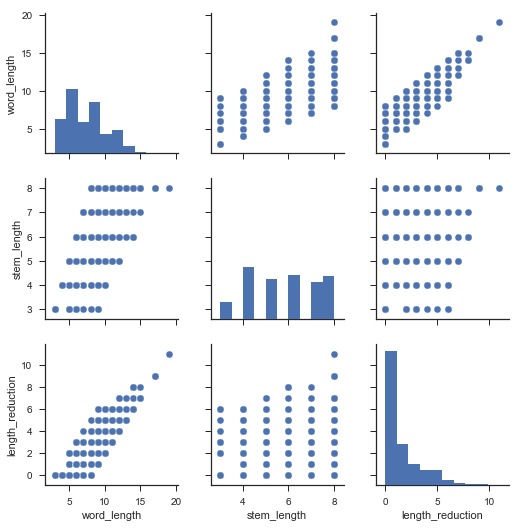

In [91]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(word_stemming_df_)

#### Analyze word conflation errors
Word conflation errors: non-related words that are mapped to the same stem.

In [92]:
# Create dictionary of conflated words

word_map2_dict_ = defaultdict(str)      #dictionary of words that will be replaced/conflated with a (different) word stem
inverse_word_map2_dict_ = defaultdict(list)   #dictionary of word stems and list of all their corresponding words

for w in distinct_corpus_words_:
    w_stem = my_stemmer(w)
    if w_stem in word_map1_dict_:
        w_stem = my_stemmer(word_map1_dict_[w_stem])
    if w_stem != w:
        word_map2_dict_[w] = w_stem
    inverse_word_map2_dict_[w_stem].append(w)

assert(len(distinct_corpus_words_) >= len(inverse_word_map2_dict_))
assert(len(distinct_corpus_words_) >= len(word_map2_dict_))
#assert(set(list(inverse_word_map2_dict_.keys())) & set(list(word_map2_dict_.keys())) == set())

print(len(distinct_corpus_words_),len(inverse_word_map2_dict_),len(word_map2_dict_))
print(set(list(inverse_word_map2_dict_.keys())) & set(list(word_map2_dict_.keys())))

1510 1303 1061
{'divers', 'continue', 'étranger', 'quelques', 'petit'}


In [93]:
'aid' in inverse_word_map2_dict_
inverse_word_map2_dict_['aid']

['aider', 'aid']

In [94]:
# Number of word stems with more than one mapped word
L = [1 for k,v in inverse_word_map2_dict_.items() if len(v)>1]
len(inverse_word_map2_dict_),len(L)

(1303, 160)

In [95]:
# Visually inspect conflated words (multiple words mapped to same word)
for k,v in inverse_word_map2_dict_.items():
    if len(v)>1:
        print(k,v)

pai ['payée', 'payés', 'payer']
homm ['homme', 'hommes']
civilis ['civilisés', 'civilisation']
individu ['individuelles', 'individus']
fort ['forts', 'forte']
integr ['intégré', 'intégrité', 'intégrer', 'intégration']
autr ['autres', 'autre']
état ['états', 'état', 'étatique']
cultur ['culturelle', 'culture', 'culturellement']
social ['socialement', 'sociale', 'sociaux']
reconnai ['reconnaissant', 'reconnaissance']
principa ['principale', 'principalement']
cher ['cher', 'chères', 'chère']
équip ['équipés', 'équipe']
tranquil ['tranquillité', 'tranquille']
fiscal ['fiscal', 'fiscalité', 'fiscaux']
rejet ['rejette', 'rejet']
main ['mains', 'main']
problem ['problème', 'problemes']
élev ['élèvé', 'élevé']
aid ['aider', 'aid']
don ['don', 'donne', 'donner']
professi ['professionnelle', 'professionnellement', 'professionnel', 'professionnalisme']
human ['humaniste', 'human']
posit ['positivement', 'positif']
quitt ['quitter', 'quitterai']
tunis ['tunisie', 'tunisienne']
garant ['garantira',

#### Apply stemming on corpus

In [96]:
u = [[word_map2_dict_[word] if word in word_map2_dict_ else word for word in sent] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)

corpus_sent_df.head()

,sentence,qlabel,tokenized_sent
0,"mes études, ma famille et mon entourage",1,"[étud, famill, entourag]"
1,Rien,1,[rien]
2,La mentalité,1,[mental]
3,Qualité de vie,1,"[qualit, vie]"
4,Une bonne ambiance de travail,1,"[bon, ambianc, travail]"


In [97]:
corpus_words_after_stemming_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist5 = FreqDist(corpus_words_after_stemming_)
assert(fdist5.N()==fdist4.N() and fdist4.B()>=fdist5.B())
print(fdist4.N(),fdist4.B())
print(fdist5.N(),fdist5.B())

6036 1510
6036 1303


In [98]:
for c in (set(list(word_map2_dict_.keys())) & set(corpus_words_after_stemming_)):
    print(c,word_map2_dict_[c],inverse_word_map2_dict_[c],fdist3[c],fdist4[c])

divers diver ['diversité'] 1 1
continue continu ['continuellement'] 3 4
étranger étrang ['étrangère'] 102 130
quelques quelqu ['quelquesoit'] 3 4
petit pet ['petites'] 2 2


In [99]:
for c in ['comfort', 'confort', 'confortables', 'confortable', 'comfortable']:
    print(c,fdist3[c],fdist4[c],fdist5[c])

comfort 1 0 0
confort 1 2 5
confortables 1 0 0
confortable 1 0 0
comfortable 1 3 0


In [100]:
for c in ['œuvre', 'œuvr', 'oeuvre', 'oeuvr']:
    print(c,fdist3[c],fdist4[c],fdist5[c])

œuvre 3 3 0
œuvr 0 0 3
oeuvre 16 16 0
oeuvr 0 0 16


In [101]:
for c in ['besoins', 'besoin', 'aid', 'aider']:
    print(c,fdist3[c],fdist4[c],fdist5[c])

besoins 2 3 0
besoin 1 0 3
aid 1 1 2
aider 1 1 0


*Observations & conclusions*
- Word reduction ratio: 1847 distinct words --> 1411 distinct words.
- **Precision** errors: 2 or more unrelated words mapped/conflated to the same stem: {'mentalité', 'mentale', 'mentalités', 'mentalit'}, {'certains', 'certainement'}
- **Recall** errors: words that should have been mapped to the same word but weren't. TO DO ...

- Some errors I noticed:

'œuvre' --> 'œuvr' 

'oeuvre' --> 'oeuvre'

### Remove empty documents

In [102]:
len(corpus_sent_df)

1418

In [103]:
# which documents are empty
idx = [i for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]
#len(idx),len(corpus_sent_df)
corpus_sent_df.iloc[idx,:]

,sentence,qlabel,tokenized_sent
367,!,3,[]
390,1€=3dt,3,[]
836,!,5,[]
911,A,5,[]
922,-,5,[]
1206,.,6,[]
1215,!,6,[]
1219,-,6,[]
1236,!,6,[]


In [104]:
corpus_sent_df = corpus_sent_df[corpus_sent_df.apply(lambda row: len(row['tokenized_sent'])>0,axis=1)]
len(corpus_sent_df)

1409

***

## Exploratory Analysis of document length distribution
Get a general idea about corpus content. Things to look for:
- Are documents homogeneous in terms of size?
- Are there any outliers that should be removed from corpus?

In [105]:
L1 = [len(doc) for doc in corpus_sent_df.tokenized_sent]
L2 = [len(' '.join(doc)) for doc in corpus_sent_df.tokenized_sent]
doc_len_df_ = pd.DataFrame({'n_words' : L1, \
                           'n_chars' : L2, \
                           'n_chars_per_word' : np.array(L2)/np.array(L1)})
doc_len_df_.head()

,n_chars,n_chars_per_word,n_words
0,20,6.666667,3
1,4,4.000000,1
2,6,6.000000,1
3,10,5.000000,2
4,19,6.333333,3


In [106]:
doc_len_df_.describe()

,n_chars,n_chars_per_word,n_words
count,1409.000000,1409.000000,1409.000000
mean,27.171043,6.211744,4.283889
std,27.542629,1.034898,4.296904
min,3.000000,3.000000,1.000000
25%,8.000000,5.666667,2.000000
50%,19.000000,6.238095,3.000000
75%,35.000000,7.000000,5.000000
max,407.000000,8.666667,71.000000


In [107]:
#doc_len_df_.corr()

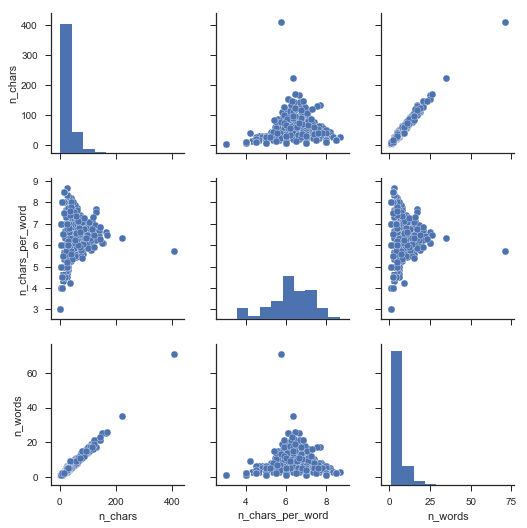

In [108]:
g = sns.pairplot(doc_len_df_)

In [109]:
# documents that contain only one word
#corpus_sent_df.tokenized_sent[doc_len_df_.n_words==1]
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==1]).value_counts().head(10)

famill      65
rien        47
tourism     26
mental      23
respect     15
salair      13
travail      8
tout         7
professi     7
travaill     7
dtype: int64

In [110]:
# documents that contain 2 words
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==2]).value_counts().head(10)

sais pas             16
qualit vie           10
bon salair           10
niveau vie            9
mode vie              4
famill amis           4
meilleur opportun     3
condit travail        3
condit vie            3
opportun travail      3
dtype: int64

In [111]:
# documents that contain 3 words
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==3]).value_counts().head(10)

salair mode vie           2
qualit vie exist          2
bon condit travail        2
mental niveau vie         2
salair condit travail     2
question trop vagu        2
plus opportun étrang      2
salair environ travail    2
mental mode vie           2
particip reconstr pays    1
dtype: int64

In [112]:
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)>20])

0     gens font lieux lieux font pas gens prend pays...
1     fait veux fair bien pays grâc connaiss train a...
2     pays plus stabl strateg bien défin vision réal...
3     histoir ancien récent pays peut incit gens ven...
4     climat devis continue chut ingénieu bien quali...
5     augment salair chang mental employeu chang men...
6     reconnaî valeur ajout jugé travail object clai...
7     curios explor nouvel coutum nouvel cultur nouv...
8     entre famill amis langu maternel travail oubl ...
9     étrang plus ouvert gens cultiv cest conscien g...
10    tunis shaabh mokho mlahhim msattik tastik bagr...
11    compar niveau professi difficil car peuvent ra...
12    plus grand motiv sein entrepri étrang encadr m...
13    travail plus appréci conscien gens plus fort c...
14    conséque ingénieu épanou professi rend plus im...
dtype: object

*Observations & conclusions*
- overall very short documents; 75% contain 5 words or less. Only 2% contain 20 words or more.
- **TO DO**: should maybe remove documents that are longer than 20 words (outliers). ???

******

## Exploratory Analysis of Word Frequency Distribution

- Analyze and visualize frequency distribution of words across entire corpus and across indivudal documents.
- Are there stopwords among most frequent words?
- might help us determine how to represent documents (using TF or TF\*IDF).

In [113]:
fdist5.N(),fdist5.B()

(6036, 1303)

In [114]:
## fraction of hapaxes
len(fdist5.hapaxes())/fdist5.B()

0.5410590943975442

In [115]:
fdist5.most_common(10)

[('plus', 164),
 ('tunis', 160),
 ('travail', 156),
 ('vie', 149),
 ('salair', 144),
 ('étrang', 131),
 ('respect', 108),
 ('pas', 102),
 ('famill', 100),
 ('bon', 87)]

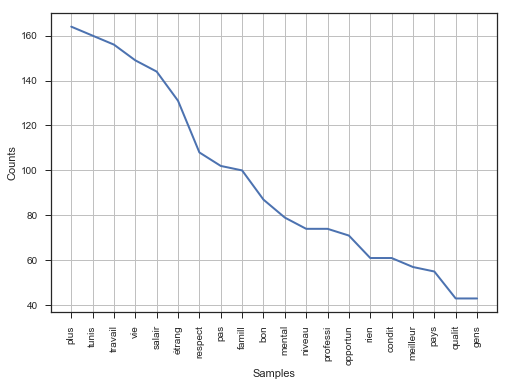

In [116]:
fdist5.plot(20,cumulative=False)

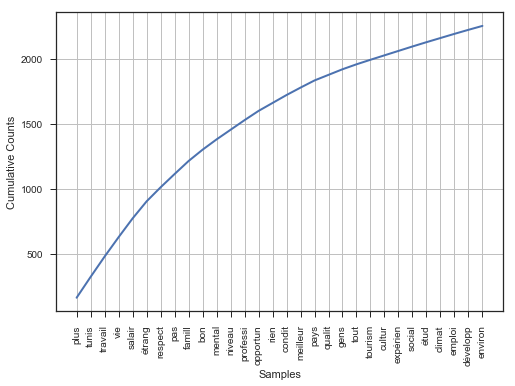

In [117]:
# cumulative frequency distribution of top 30 words in this corpus
fdist5.plot(30,cumulative=True)

*Observations & conclusions*
- corpus contains 1311 unique/distinct words.
- 52% of words are *hapaxes* (words that occur only once in entire corpus).
- 30 most common words account for ~30% of all word occurrences.
- Word distribution seems to follow the typical Zipf distribution.

****

## Collocation Detection
- Distribution of Word Bigrams and Trigrams.
- Are there any frequent bigrams or trigrams?
- Should we use Bag-of-ngrams model with n>1 ?

**To be finished ...**

Collocations I have noticed in this corpus:
- Main d'oeuvre
- Je ne sais pas
- Dinar tunisien

In [118]:
[(i,doc) for i,doc in enumerate(corpus_sent_df.sentence) if 'sais pas' in doc]

[(192, 'Je sais pas encore'),
 (323, 'Je sais pas'),
 (463, 'Je sais pas'),
 (496, 'Je sais pas je peux pas penser à rien'),
 (504, 'Je ne sais pas'),
 (507, 'Je sais pas'),
 (874, 'Je ne sais pas'),
 (911, 'Je ne sais pas'),
 (982, 'Je sais pas'),
 (1041,
  "Je ne sais pas, mais j'imagine qu'il y aurait une différente mentalité"),
 (1053, 'je ne sais pas'),
 (1107, 'je sais pas'),
 (1201, 'je ne sais pas'),
 (1202, 'je ne sais pas'),
 (1249, 'Je ne sais pas jai pas encore intégré le milieu professionnel'),
 (1294, 'Je ne sais pas'),
 (1353, 'je ne sais pas'),
 (1371, 'Je sais pas'),
 (1405, 'je sais pas')]

In [119]:
from nltk import collocations

In [120]:
u = [[word for word in doc] + ['.'] for doc in corpus_sent_df.tokenized_sent]
u[0:3]

[['étud', 'famill', 'entourag', '.'], ['rien', '.'], ['mental', '.']]

In [121]:
corpus_words_list_with_separator = [word for doc in u for word in doc]
# corpus_words_list_with_separator[0:10]

In [122]:
bigram_measures = collocations.BigramAssocMeasures()
bigram_finder = collocations.BigramCollocationFinder.from_words(corpus_words_list_with_separator)

In [123]:
# number of unique bigrams
len(bigram_finder.score_ngrams(bigram_measures.raw_freq))

4436

In [124]:
# most frequent bigrams
bigram_finder.nbest(bigram_measures.raw_freq, 10)

[('.', 'famill'),
 ('famill', '.'),
 ('vie', '.'),
 ('.', 'bon'),
 ('tunis', '.'),
 ('travail', '.'),
 ('.', 'rien'),
 ('rien', '.'),
 ('.', 'salair'),
 ('.', 'mental')]

In [125]:
bigram_finder.nbest(bigram_measures.likelihood_ratio, 10)

[('niveau', 'vie'),
 ('main', 'oeuvr'),
 ('.', 'famill'),
 ('sais', 'pas'),
 ('condit', 'travail'),
 ('famill', '.'),
 ('qualit', 'vie'),
 ('.', 'rien'),
 ('rien', '.'),
 ('mode', 'vie')]

In [126]:
bigram_finder.nbest(bigram_measures.pmi, 10)

[('accessib', 'efficac'),
 ('alcool', 'vendred'),
 ('alin', 'irawho'),
 ('allemagn', 'japan'),
 ('arabo', 'musulman'),
 ('arrog', 'impun'),
 ('attent', 'puis'),
 ('ayy', 'rajel'),
 ('bagr', 'felhin'),
 ('bou', 'said')]

In [127]:
bigram_finder.nbest(bigram_measures.chi_sq, 10)

[('accessib', 'efficac'),
 ('alcool', 'vendred'),
 ('alin', 'irawho'),
 ('allemagn', 'japan'),
 ('arabo', 'musulman'),
 ('arrog', 'impun'),
 ('attent', 'puis'),
 ('ayy', 'rajel'),
 ('bagr', 'felhin'),
 ('bou', 'said')]

In [128]:
bigram_finder.nbest(bigram_measures.dice, 10)

[('accessib', 'efficac'),
 ('alcool', 'vendred'),
 ('alin', 'irawho'),
 ('allemagn', 'japan'),
 ('arabo', 'musulman'),
 ('arrog', 'impun'),
 ('attent', 'puis'),
 ('ayy', 'rajel'),
 ('bagr', 'felhin'),
 ('bou', 'said')]

In [129]:
bigram_finder.nbest(bigram_measures.jaccard, 10)

[('accessib', 'efficac'),
 ('alcool', 'vendred'),
 ('alin', 'irawho'),
 ('allemagn', 'japan'),
 ('arabo', 'musulman'),
 ('arrog', 'impun'),
 ('attent', 'puis'),
 ('ayy', 'rajel'),
 ('bagr', 'felhin'),
 ('bou', 'said')]

In [130]:
bigram_finder.nbest(bigram_measures.mi_like, 10)

[('main', 'oeuvr'),
 ('niveau', 'vie'),
 ('point', 'vue'),
 ('.', 'famill'),
 ('sais', 'pas'),
 ('condit', 'travail'),
 ('famill', '.'),
 ('veut', 'dire'),
 ('qualit', 'vie'),
 ('shaab', 'ton')]

In [131]:
# Remove bigrams that occur less than 3 times
bigram_finder.apply_freq_filter(3)
len(bigram_finder.score_ngrams(bigram_measures.raw_freq))

356

In [132]:
trigram_measures = collocations.TrigramAssocMeasures()
trigram_finder = collocations.TrigramCollocationFinder.from_words(corpus_words_list_with_separator)

In [133]:
# number of unique trigrams
len(trigram_finder.score_ngrams(trigram_measures.raw_freq))

6370

In [134]:
trigram_finder.apply_freq_filter(3)

In [135]:
len(trigram_finder.score_ngrams(trigram_measures.raw_freq))

153

In [136]:
# most frequent trigrams
trigram_finder.nbest(trigram_measures.raw_freq, 10)

[('.', 'famill', '.'),
 ('.', 'rien', '.'),
 ('.', 'tourism', '.'),
 ('.', 'niveau', 'vie'),
 ('.', 'mental', '.'),
 ('famill', '.', 'famill'),
 ('.', 'sais', 'pas'),
 ('niveau', 'vie', '.'),
 ('qualit', 'vie', '.'),
 ('sais', 'pas', '.')]

*Observations & Conclusions*
- A few bigrams but no trigrams within the same document.
- Hence Bag-of-ngrams model with n=2 seems adequate.

******

##  Text Representation with BOW
1. Extract important vocabulary terms
2. Construct various DTMs of corpus

### Construct Vocabulary

In [137]:
# Configuration parameters of the BOW model
maxdf = 1.0   #because no stopwords (see previous section)
mindf = 3     #eliminate rare words
ngram_range=(1, 2)   #because corpus contains a few frequent bigrams (see previous section)

In [138]:
tf_bow_model = CountVectorizer(max_df=maxdf, min_df=mindf, stop_words=None, ngram_range=ngram_range)  ## max_features=100

In [139]:
# Convert documents from word lists to strings
corpus_docs_clean_ = [' '.join(doc) for doc in corpus_sent_df.tokenized_sent]
assert(len(corpus_docs_clean_) == len(corpus_sent_df))

In [140]:
tf_bow_model.fit(corpus_docs_clean_)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [141]:
## verify the vocabulary -- each element of vocabulary is a single word or bigram
tf_bow_vocab = tf_bow_model.get_feature_names()
type(tf_bow_vocab),len(tf_bow_vocab)

(list, 543)

In [142]:
# Terms that were ignored because they either:
#      - occurred in too many documents (`max_df`)
#      - occurred in too few documents (`min_df`)
#      - were cut off by feature selection (`max_features`).

# Notice that this is much larger than fdist5.B() because of the bigrams ...
len(tf_bow_model.stop_words_)

4392

### Raw Counts DTM
Calculate DTM of our corpus.

In [143]:
tf_bow_dtm = tf_bow_model.transform(corpus_docs_clean_)
type(tf_bow_dtm),tf_bow_dtm.shape

(scipy.sparse.csr.csr_matrix, (1409, 543))

### TFIDF DTM

In [144]:
tfidf_transformer = TfidfTransformer(use_idf=True, smooth_idf=True, norm = None, sublinear_tf=False).fit(tf_bow_dtm)   ##norm = 'l1'

In [145]:
tfidf_bow_dtm = tfidf_transformer.transform(tf_bow_dtm)
type(tfidf_bow_dtm),tfidf_bow_dtm.shape

(scipy.sparse.csr.csr_matrix, (1409, 543))

### Visualize DTM

In [146]:
# range of values in this matrix
tf_bow_dtm.min(),tf_bow_dtm.max()

(0, 5)

In [147]:
# Fraction of non-zero elements that are equal to 1
(tf_bow_dtm==1).sum() / tf_bow_dtm.nnz

0.9714540588760036

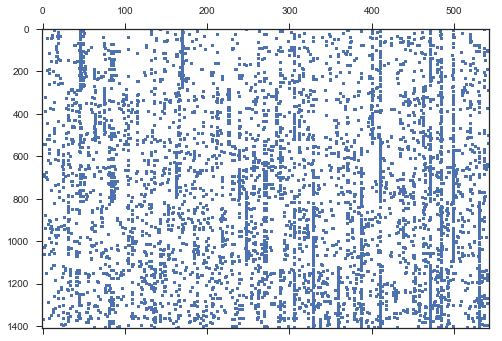

In [148]:
plt.spy(tf_bow_dtm,precision=0, markersize=3, aspect='auto')

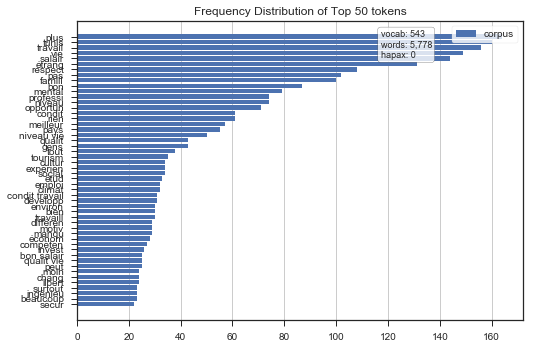

In [149]:
visualizer = FreqDistVisualizer(features=tf_bow_vocab)
visualizer.fit(tf_bow_dtm)
visualizer.poof()

In [150]:
# Distribution of non-zero TFIDF values
u = tfidf_bow_dtm.data
assert(len(u)==tfidf_bow_dtm.nnz)
type(u),len(u)

(numpy.ndarray, 5605)

In [151]:
pd.Series(u).describe()

count    5605.000000
mean        5.264627
std         1.437035
min         3.214392
25%         4.002850
50%         5.255613
75%         6.305435
max        16.804979
dtype: float64

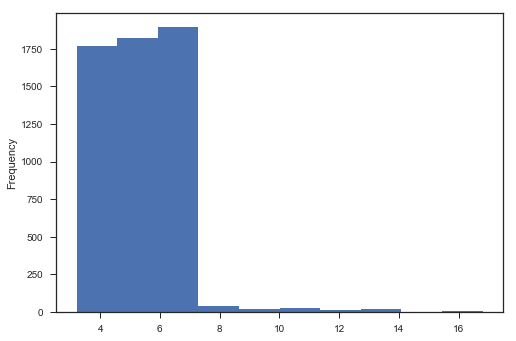

In [152]:
pd.Series(u).plot(kind='hist')

****

## Remove documents that contain NO vocabulary terms

In [153]:
nb_terms_per_doc_ = np.array((tf_bow_dtm>0).sum(axis=1)).ravel()
nb_terms_per_doc__ = np.array((tfidf_bow_dtm!=0).sum(axis=1)).ravel()
assert(np.all(nb_terms_per_doc__==nb_terms_per_doc_))

In [154]:
# Which documents do NOT contain any vocabulary terms
assert(nb_terms_per_doc_.shape[0]==len(corpus_sent_df))
print(np.sum(nb_terms_per_doc_==0))
corpus_sent_df.iloc[nb_terms_per_doc_==0,:]

28


,sentence,qlabel,tokenized_sent
25,Jimie hendrix... rhcp .. Nick johnston...,1,"[jim, hendrix, rhcp, nick, johnston]"
152,idk,1,[idk]
164,Paix,1,[paix]
176,l'attachement émotionnel,1,"[attach, émotionn]"
181,omi wo baba,1,"[omi, baba]"
220,mon mari,1,[mari]
300,Famma hatta sabab ijiw yitfarjo w yidhahko ali...,3,"[famm, hatt, sabab, ijiw, yitfarjo, yidhahko, ..."
368,Amitié,3,[amiti]
374,Logement nourriture,3,"[log, nourritu]"
403,sidi bou said,3,"[sidi, bou, said]"


In [155]:
print(len(corpus_sent_df))
corpus_sent_df = corpus_sent_df.iloc[nb_terms_per_doc_>0,:]
print(len(corpus_sent_df))

1409
1381


In [156]:
corpus_sent_df.shape

(1381, 3)

In [157]:
tf_bow_dtm = tf_bow_dtm[nb_terms_per_doc_>0,:]
tfidf_bow_dtm = tfidf_bow_dtm[nb_terms_per_doc_>0,:]

In [158]:
assert(np.all(tf_bow_dtm.shape==tfidf_bow_dtm.shape) and tf_bow_dtm.shape[0] == len(corpus_sent_df))

****

## Meta-Features of Vocabulary Terms
- Input: DTM and vocabulary list.
- Output: word importance features (that reflect importance of a word) based on their frequency of occurrence in documents.

Main purpose of this analysis is to gain insight for effective *word scoring* in the `sumbasic` method used below ... 

**TO DO**: 
1. add other word features ???
2. visualization using tSNE ???
3. cluster analysis ???
4. perform this entire analysis separately on each question's sub-corpus (instead of combined corpus)  ???

In [159]:
tf_bow_dtm.shape,tfidf_bow_dtm.shape,len(tf_bow_vocab)

((1381, 543), (1381, 543), 543)

In [160]:
term_attributes_df = pd.DataFrame({'IDF': tfidf_transformer.idf_, \
                                  'Corpus_tf':np.array(tf_bow_dtm.sum(axis=0)).ravel(), \
                                   'DF':np.array((tf_bow_dtm>0).sum(axis=0)).ravel(), \
                                   'average_tfidf': np.array(tfidf_bow_dtm.mean(axis=0)).ravel() \
                                  }, index=tf_bow_vocab)
term_attributes_df.head()

,Corpus_tf,DF,IDF,average_tfidf
absenc,3,3,6.865051,0.014913
accept,4,4,6.641907,0.019238
accueil,3,3,6.865051,0.014913
achat,3,3,6.865051,0.014913
acquer,3,3,6.865051,0.014913


In [161]:
# Fraction of terms that occur at most once in any document
np.mean(term_attributes_df.DF == term_attributes_df.Corpus_tf)

0.8692449355432781

In [162]:
# Which vocablary ters occur more than once in a document
term_attributes_df.loc[term_attributes_df.DF < term_attributes_df.Corpus_tf,:].sort_values('Corpus_tf',ascending=False).head(10)

,Corpus_tf,DF,IDF,average_tfidf
plus,164,132,3.360996,0.399133
tunis,160,153,3.214392,0.372413
travail,156,146,3.260912,0.368358
vie,149,142,3.288500,0.354806
salair,144,143,3.281532,0.342173
étrang,131,130,3.376148,0.320257
respect,108,107,3.569214,0.279128
pas,102,93,3.708050,0.273875
bon,87,75,3.920612,0.246990
mental,79,78,3.881897,0.222064


In [163]:
# term_attributes_df.describe()

In [164]:
term_attributes_df.corr()

,Corpus_tf,DF,IDF,average_tfidf
Corpus_tf,1.000000,0.997612,-0.835863,0.988795
DF,0.997612,1.000000,-0.843388,0.987806
IDF,-0.835863,-0.843388,1.000000,-0.903865
average_tfidf,0.988795,0.987806,-0.903865,1.000000


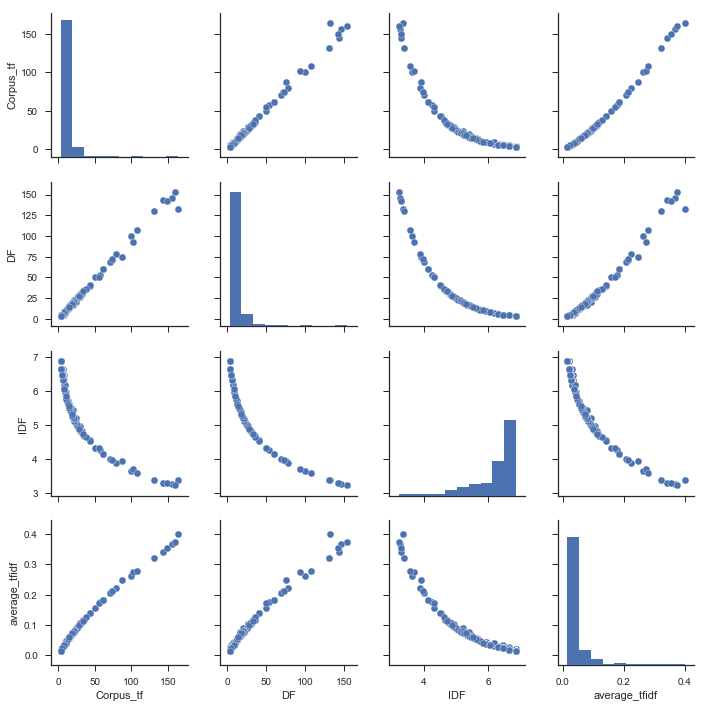

In [165]:
g = sns.pairplot(term_attributes_df)

In [166]:
term_attributes_df.sort_values('DF',ascending=False, inplace=False).head(10)

,Corpus_tf,DF,IDF,average_tfidf
tunis,160,153,3.214392,0.372413
travail,156,146,3.260912,0.368358
salair,144,143,3.281532,0.342173
vie,149,142,3.288500,0.354806
plus,164,132,3.360996,0.399133
étrang,131,130,3.376148,0.320257
respect,108,107,3.569214,0.279128
famill,100,100,3.636224,0.263304
pas,102,93,3.708050,0.273875
mental,79,78,3.881897,0.222064


In [167]:
term_attributes_df.sort_values('average_tfidf',ascending=False, inplace=False).head()

,Corpus_tf,DF,IDF,average_tfidf
plus,164,132,3.360996,0.399133
tunis,160,153,3.214392,0.372413
travail,156,146,3.260912,0.368358
vie,149,142,3.288500,0.354806
salair,144,143,3.281532,0.342173


In [168]:
S1 = set(term_attributes_df.sort_values('DF',ascending=False, inplace=False).head(10).index)
S2 = set(term_attributes_df.sort_values('average_tfidf',ascending=False, inplace=False).head(10).index)
S1 - S2, S2 - S1

({'mental'}, {'bon'})

In [169]:
S1 = set(term_attributes_df.sort_values('DF',ascending=False, inplace=False).head(20).index)
S2 = set(term_attributes_df.sort_values('average_tfidf',ascending=False, inplace=False).head(20).index)
S1 - S2, S2 - S1

({'qualit'}, {'gens'})

*Remarks & conclusions*
- ``DF`` is the document frequency of a term, ``corpus_TF`` is the number of occurrences of a term in entire corpus.
- There are 546 distinct vocabulary terms (single words and bigrams) -- words that occur in at least 3 documents.
- 87% of vocabulary terms occur only once in a document, i.e. their df and corpus_tf are the same 
- Remember that 97% of the non-zero elements of DTM are $=$1.

### Wordcloud
Plot word cloud weighted by words' document frequencies.

In [170]:
from wordcloud import WordCloud, ImageColorGenerator

(-0.5, 999.5, 499.5, -0.5)

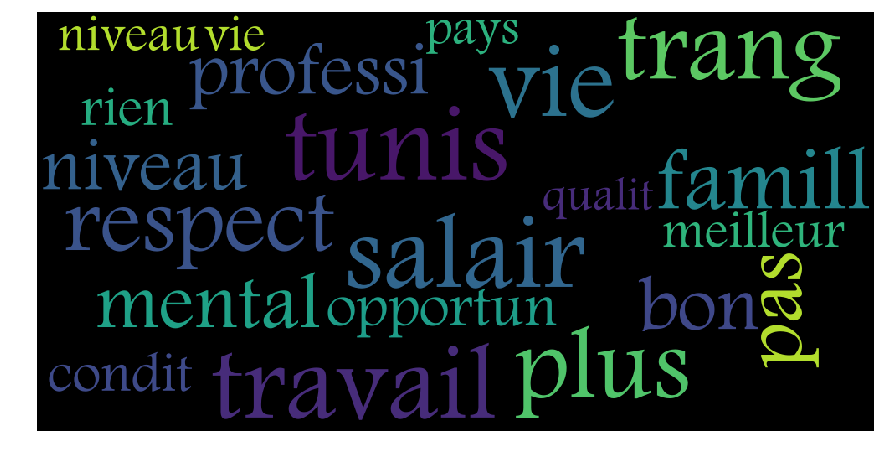

In [171]:
# hyperparameters
Max_Words = 20
MaxFont = 1200

# Create instance of class with default configuration parameters
wc = WordCloud(width = 1000, height = 500, min_font_size=3, max_words=Max_Words)

# generate a word cloud image by calling the generate_from_frequencies() method

# set the max font size for this topic
DF_norm = term_attributes_df.DF/tf_bow_dtm.shape[0]
weighted_MaxFont = int( MaxFont * np.max(DF_norm) )
d = dict(zip(tf_bow_vocab, DF_norm))
z = wc.generate_from_frequencies(d, max_font_size=weighted_MaxFont)
plt.figure(figsize=(15,8))
plt.imshow(z)
plt.axis("off")

****

## Summarization with Topic words and Sumbasic
- Inputs:
- Outputs:

### Group similar documents (via CC analysis)
Find groups of similar documents so that the summary includes only at most one member of any document group.

In [169]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

#### Method 1: jaccard similarity of boolean DTM + CC analysis

In [170]:
def find_similar_sents1(tf_dtm,thresh=0.5,disp_flag=False,sentences=[]):

    ## Calculate distance matrix (between every pair of documents)
    D = squareform(pdist((tf_dtm>0).todense(), metric = 'jaccard'))

    # remove self-edges
    for i in range(D.shape[0]):
        D[i,i] = 1

    ## Build undirected graph by thresholding distance matrix
    rows,cols = np.where(D<thresh)
    assert(np.all(rows!=cols))

    g1 = nx.Graph()
    g1.add_edges_from(zip(rows,cols))

    ## Extract CCs, and sort them by size
    CCs = [c for c in sorted(nx.connected_components(g1), key=len, reverse=True)]

    W = 1-D
    rows2,cols2 = np.where(W>1-thresh)
    assert(len(rows2)==len(rows))
    assert(np.all(rows2!=cols2))

    weights = W[W>1-thresh]
    assert(len(weights) == len(rows2))
    assert(np.min(weights)>=thresh)

    x = g1.number_of_nodes()
    y = g1.number_of_edges()
    g1.add_weighted_edges_from(zip(rows2,cols2,weights))
    assert(x == g1.number_of_nodes() and y == g1.number_of_edges())

    ## Evaluate quality of CCs
    L = []
    for cc in CCs:
        n = len(cc)
        e = g1.subgraph(cc).number_of_edges()
        w = [z['weight'] for x,y,z in list(g1.subgraph(cc).edges.data())]
        L.append((n,e,e/(n*(n-1)/2), np.median(w)))
    CC_prop_df = pd.DataFrame(L)
    CC_prop_df.columns = ['n_nodes','n_edges','cohesion','median_weight']

    ## TO DO: remove CCs with low cohesion and/or low average weight

    ## label each sentence with corresponding CC
    CC_labels_vec = np.empty((tf_dtm.shape[0],))
    for cc_label,cc in enumerate(CCs):
        for i in cc:
            CC_labels_vec[i] = cc_label

    assert(np.any(np.isnan(CC_labels_vec)) == False)


    ## Visualize results
    if disp_flag:
        print("Graph size: nodes %d, edges %d" % (g1.number_of_nodes(),g1.number_of_edges()))
        print("")

        print("Number of connected components: %d" % len(CCs))
        print('Distribution of CC sizes:')
        print(pd.Series([len(cc) for cc in CCs]).value_counts())
        print("")

        print("Cohesion analysis of the CCs:")
        CC_prop_df.sort_values('n_nodes', ascending=False, inplace=True)
        print(CC_prop_df[CC_prop_df.n_nodes>1])
        print("")
        print("")

        #CC_prop_df.plot.scatter('n_nodes','cohesion')
        #CC_prop_df.plot.scatter('n_nodes','median_weight')

        if len(sentences) > 0 :
            assert(len(sentences)==tf_dtm.shape[0])
            print("Sentences in each CC:")
            print("")
            for cc in CCs:
                n_nodes = len(cc)
                if n_nodes == 1:
                    continue
                n_edges = g1.subgraph(cc).number_of_edges()
                print("CC: %d nodes, %d edges, %.3f cohesion" % (n_nodes,n_edges,n_edges/(n_nodes*(n_nodes-1)/2)))
                for i in cc:
                    print(sentences.iloc[i])
                print("")

    return CC_labels_vec,CC_prop_df

#### Method 2: cosine similarity of topic words tfidf DTM + CC analysis

In [171]:
def find_similar_sents2(sentences,tf_dtm,vocab,topic_words_df,thresh=0.2):
    assert(len(sentences)==tf_dtm.shape[0] and len(vocab)==tf_dtm.shape[1])

    u = pd.Series(range(len(vocab)),index=vocab)
    topic_words_idx = u[topic_words_df.index].tolist()
    topic_words_scores = np.array(topic_words_df.tolist())
    assert(len(topic_words_scores) == len(topic_words_idx))

    topic_words_dtm = np.empty((tf_dtm.shape[0],len(topic_words__)))
    for i in range(topic_words_dtm.shape[0]):
        topic_words_dtm[i,:] = topic_words_scores*np.array((tf_dtm[i,topic_words_idx]>0).todense()).ravel()

    #remove zero rows
    #idx = topic_words_dtm.sum(axis=1) > 0
    #topic_words_dtm = topic_words_dtm[idx,:]

    D = squareform(pdist(topic_words_dtm, metric = 'cosine'))

    rows,cols = np.where((~np.isnan(D)) & (D<thresh))

    doc_graph_ = nx.Graph() # empty UNDIRECTED graph
    doc_graph_.add_edges_from(zip(rows,cols))

    print("Graph size: nodes %d, edges %d" % (len(doc_graph_.nodes()),len(doc_graph_.edges())))
    print("")

    CCs = [c for c in sorted(nx.connected_components(doc_graph_), key=len, reverse=True)]
    print("Number of connected components: %d" % len(CCs))
    print("")

    print('Distribution of CC sizes:')
    print(pd.Series([len(cc) for cc in CCs]).value_counts())
    print("")

    print("Sentences in the CCs:")
    print("")
    for cc in CCs:
        #assert(len(cc) >= 2)
        if len(cc) == 1:
            continue
        for ii in cc:
            print(sentences.iloc[ii])
        print("")

#### Test method1 on corpus of each question

In [172]:
corpus_sent_df.qlabel.unique()

array([1, 3, 4, 5, 6], dtype=int64)

In [173]:
question_labels = corpus_sent_df.qlabel.unique()
#question_labels = [4, 5, 1, 6, 3]

Question  1

Graph size: nodes 128, edges 2199

Number of connected components: 18
Distribution of CC sizes:
2     10
4      2
3      2
15     1
9      1
6      1
64     1
dtype: int64

Cohesion analysis of the CCs:
    n_nodes  n_edges  cohesion  median_weight
0        64     2016  1.000000       1.000000
1        15      105  1.000000       1.000000
2         9       36  1.000000       1.000000
3         6       15  1.000000       0.666667
4         4        6  1.000000       1.000000
5         4        6  1.000000       1.000000
6         3        2  0.666667       0.666667
7         3        3  1.000000       0.625000
13        2        1  1.000000       1.000000
16        2        1  1.000000       1.000000
15        2        1  1.000000       1.000000
14        2        1  1.000000       1.000000
9         2        1  1.000000       0.750000
12        2        1  1.000000       1.000000
11        2        1  1.000000       1.000000
10        2        1  1.000000       1.000000
8 



Sentences in each CC:

CC: 21 nodes, 210 edges, 1.000 cohesion
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental', 'popul']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']
['mental']

CC: 10 nodes, 45 edges, 1.000 cohesion
['empath', 'respect']
['respect']
['respect']
['respect']
['respect']
['respect']
['respect', 'paix', 'generosi']
['respect']
['respect']
['respect']

CC: 6 nodes, 15 edges, 1.000 cohesion
['niveau', 'vie']
['niveau', 'vie']
['niveau', 'vie', 'mieux']
['niveau', 'vie']
['niveau', 'vie', 'médiocr']
['niveau', 'vie']

CC: 6 nodes, 15 edges, 1.000 cohesion
['qualit', 'vie']
['qualit', 'vie']
['qualit', 'vie']
['libert', 'qualit', 'vie']
['qualit', 'vie']
['qualit', 'vie']

CC: 5 nodes, 10 edges, 1.000 cohesion
['toler']
['toler']
['toler']
['toler']
['toler']

CC: 5 nodes, 10 edges, 1.000 cohesion
['cosmopol', 'ouvertur', 'esprit', 'progress']
['ouve

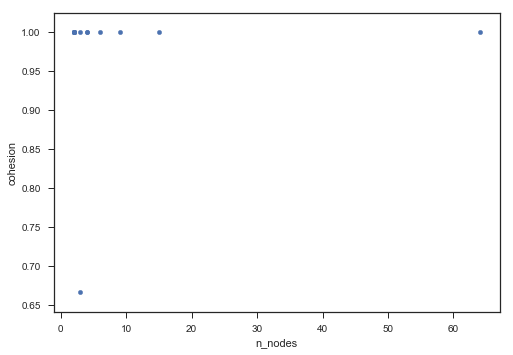

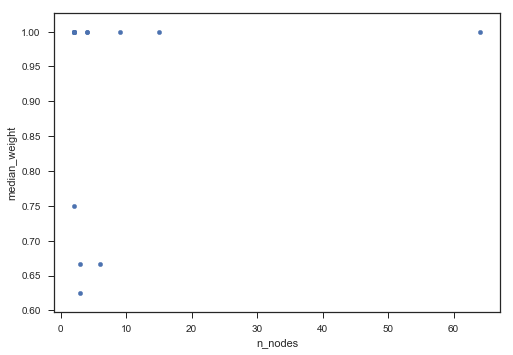

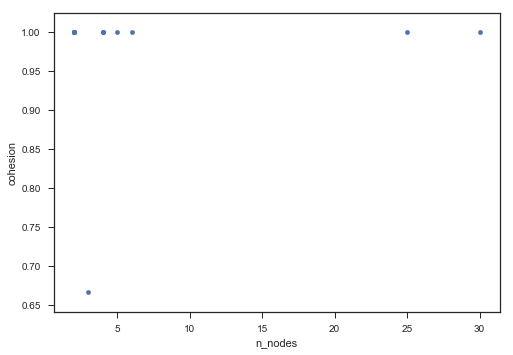

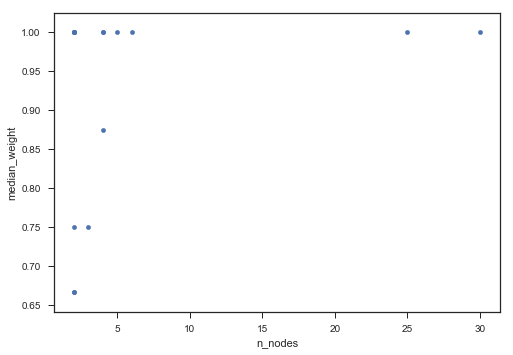

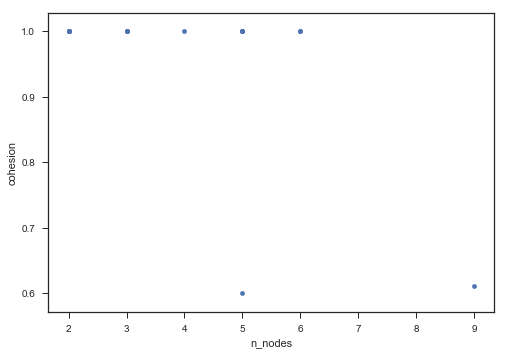

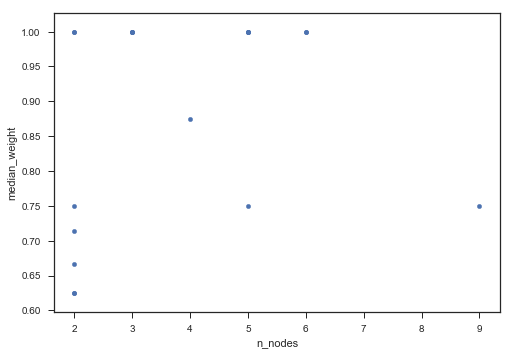

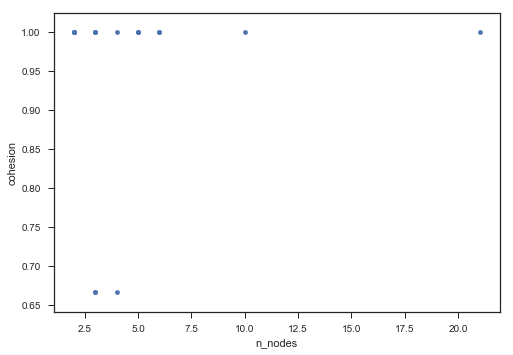

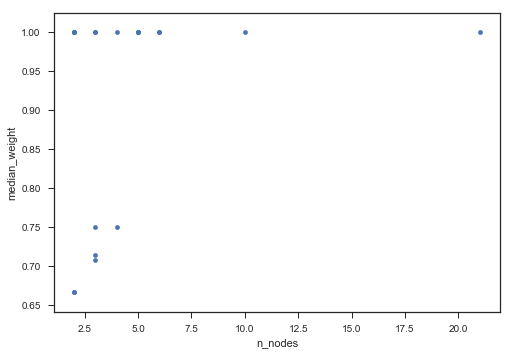

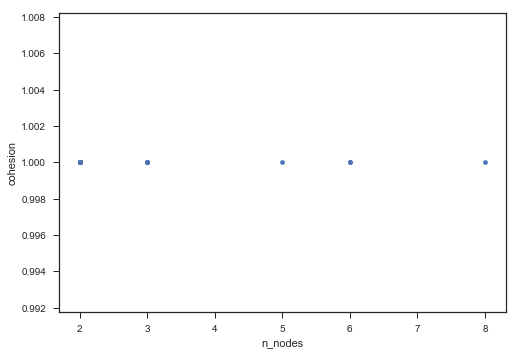

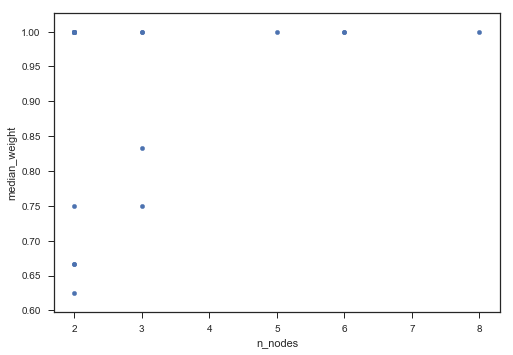

In [177]:
for j in question_labels:
    print("Question ", j)
    print("")

    idx = np.array(corpus_sent_df.qlabel).ravel() == j
    Q_sentences = corpus_sent_df.tokenized_sent[idx]
    Q_tf_dtm = tf_bow_dtm[idx,:]
    #Q_tfidf_dtm = tfidf_bow_dtm[idx,:]

    find_similar_sents1(Q_tf_dtm,0.4,True,Q_sentences)

    #word_scores_df,topic_words = word_scoring_tfidf(Q_tfidf_dtm,tf_bow_vocab)
    #find_similar_sents(Q_sentences,Q_tf_dtm,tf_bow_vocab,word_scores_df[topic_words], thresh=0.1)

In [176]:
CC_labels_vec,CC_prop_df = find_similar_sents1(Q_tf_dtm,0.4)
print(np.sum(np.isnan(CC_labels_vec)))
assert(np.any(np.isnan(CC_labels_vec)) == False)

0


*Observations & conclusions*
- Documents that contain only 1 or 2 vocabulary terms : the terms they contain are actually quite significant/meaningful.
- Possible good feature for word scoring: whether the word occurs in *very* short documents.

In [178]:
'bon salair' in inverse_word_map2_dict_.keys()

False

In [179]:
len(inverse_word_map2_dict_)

1303

### SumBasic Algorithm Implementation
Greedy algorithm:
- for each topic word,
- score documents based on current word scores
- select top N documents that contain this word
- discount the score or weight of this word so that it has less importance in future selected documents

**Question**: currently word scoring is done separately with each question's sub-corpus. Should we do it with the combined corpus instead?

In [180]:
# TFIDF-based method: word score = average tfidf weight over all documents in corpus
def word_scoring_tfidf(tfidf_dtm,vocab,N=10,thresh=0):
    v = np.array(tfidf_dtm.mean(axis=0)).ravel()
    word_scores_df = pd.Series(v, index=vocab)

    # Set weights of non-topic words to 0
    word_scores_df[word_scores_df<thresh] = 0
    u = word_scores_df.sort_values(ascending=False, inplace=False)
    word_scores_df[u.index[N:len(word_scores_df)]] = 0

    topic_words = u.head(N).index.tolist()

    assert(np.all(vocab==word_scores_df.index))

    return word_scores_df,topic_words

In [181]:
# log-likelihood-based method
#def word_scoring_lle(tf_dtm):


**TO DO**: revise the document scoring formula. Currently using (~) average score of topic words in the document.

In [182]:
#basic method: normalized sum of word scores over all TOPIC words in this doc
def doc_scoring(tf_dtm,word_scores_df,thresh=3):
    ##Inputs:
    #  tf_dtm: DTM containing raw frequency counts of words in documents
    #  word_scores_df: a Series indexable by vocab words, where order of words must be same as in DTM    
    ##Outputs: list of document scores
    ##Pre-conditions: word_scores_df.index == list of vocabulary terms in DTM

    #verify pre-conditions
    assert(tf_dtm.shape[1] == len(word_scores_df))

    doc_scores = []
    n = tf_dtm.shape[0]

    # iterate over all documents
    for i in range(n):
        #select the vocab words present in this document
        #just select non-zero elements of DTM row corresponding to this doc
        idx = np.array((tf_dtm[i,:]>0).todense()).ravel()

        #calculate this document's score as a function of its words' scores
        doc_score = word_scores_df[idx].sum()

        #normalize score
        k = np.sum(idx)
        #q = k+1
        #q = max(thresh,k/2)
        q = max(thresh,k/2)
        doc_score = doc_score/q

        doc_scores.append(doc_score)

    assert(len(doc_scores) == n)

    return doc_scores

In [183]:
def sumbasic(tf_dtm,tfidf_dtm,vocab,thresh1=0,thresh2=3,N1=10,N2=2):

    assert(tf_dtm.shape[1] == len(vocab))

    word_scores_df,topic_words = word_scoring_tfidf(tfidf_dtm,vocab,N1,thresh1)
    a = word_scores_df.min()
    b = word_scores_df.max()

    #store summary documents and their scores in a dictionary indexed by the document's index in the corpus
    summary_docs = defaultdict(float)
    vocab_ = np.array(vocab)

    for word in topic_words:
        # score documents based on current word scores
        doc_scores_ = doc_scoring(tf_dtm,word_scores_df,thresh2)
        doc_scores_df_ = pd.Series(doc_scores_)

        # select top N documents that contain this word
        doc_scores_df_.sort_values(ascending=False, inplace=True)
        #print(doc_scores_df_.head())

        j = np.where(vocab_==word)[0][0]  # index of this word in the vocabulary
        k = 0
        for i,score in doc_scores_df_.iteritems():
            #i = doc_scores_df_.index[ii]
            #print(i,score)
            if i in summary_docs:
                continue
            elif tf_dtm[i,j] > 0:
                k = k+1
                summary_docs[i] = score
                if k >= N2:
                    break

        #adjust/discount this word's score so that it has less importance in future selected documents
        #TO DO: revise this discounting formula ...
        x = word_scores_df[word]
        word_scores_df[word] = x - (x-a)/2

    return summary_docs,word_scores_df[topic_words]

In [184]:
def sumbasic2(tf_dtm,tfidf_dtm,vocab,thresh1=0,thresh2=3,N1=10,N2=2):

    assert(tf_dtm.shape[1] == len(vocab))

    # build graph of similar documents so that similar documents are not repeated in the summary
    CC_labels_vec,CC_prop_df = find_similar_sents1(Q_tf_dtm,thresh=0.4)

    word_scores_df,topic_words = word_scoring_tfidf(tfidf_dtm,vocab,N1,thresh1)
    a = word_scores_df.min()
    b = word_scores_df.max()

    #store summary documents and their scores in a dictionary indexed by the document's CC label
    summary_docs = defaultdict(tuple)
    vocab_ = np.array(vocab)

    for word in topic_words:
        # score documents based on current word scores
        doc_scores_ = doc_scoring(tf_dtm,word_scores_df,thresh2)
        doc_scores_df_ = pd.Series(doc_scores_)

        # select top N documents that contain this word
        doc_scores_df_.sort_values(ascending=False, inplace=True)
        #print(doc_scores_df_.head())

        j = np.where(vocab_==word)[0][0]  # index of this word in the vocabulary
        k = 0

        if False:
            # iterate over all documents that contain this word
            idx = np.where(tf_dtm[:,j].todense() > 0)[0]  # indices of all documents that contain this word
            for i in idx:
                cc = CC_labels_vec[i]
                score = doc_scores_df_[i]
                if (cc not in summary_docs) or (summary_docs[cc][0] < score):
                    k = k+1
                    summary_docs[cc] = (score,i)
                    if k >= N2:
                        break
        else:
            # iterate over documents in decreasing order of score
            for i,score in doc_scores_df_.iteritems():
                if tf_dtm[i,j] > 0:
                    cc = CC_labels_vec[i]
                    if (cc not in summary_docs) or (summary_docs[cc][0] < score):
                        k = k+1
                        summary_docs[cc] = (score,i)
                        if k >= N2:
                            break

        #adjust/discount this word's score so that it has less importance in future selected documents
        #TO DO: revise this discounting formula ...
        x = word_scores_df[word]
        word_scores_df[word] = x - (x-a)/2

    return summary_docs,word_scores_df[topic_words]

### Apply algorithm on sub-corpus of each question

In [185]:
#sumbasic(Q_tf_dtm,Q_tfidf_dtm,tf_bow_vocab)

In [230]:
for j in question_labels:
    print(Fore.BLACK + "Summary of Question %d" % j)
    print("")

    idx = np.array(corpus_sent_df.qlabel).ravel() == j
    Q_corpus = corpus_sent_df[idx]
    Q_tf_dtm = tf_bow_dtm[idx,:]
    Q_tfidf_dtm = tfidf_bow_dtm[idx,:]
    n = np.sum(idx)
    assert(n == Q_corpus.shape[0] and n==Q_tf_dtm.shape[0] and n==Q_tfidf_dtm.shape[0])
    assert(Q_corpus.shape[1] == corpus_sent_df.shape[1])

    print(Fore.BLACK + "%d sentences:" % (n))
    print("")

    # number of words / number of unique words
    n_words = Q_tf_dtm.sum()
    n_distinct_words = (Q_tf_dtm.sum(axis=0) > 0).sum()
    print(Fore.BLACK + "Lexical diversity: %.2f" % (n_words/n_distinct_words))
    print("")


    summary_res_,topic_words_ = sumbasic2(Q_tf_dtm,Q_tfidf_dtm,tf_bow_vocab)   #thresh1=0.1,thresh2=3,N1=10,N2=2

    idx = [y for x,y in summary_res_.values()]
    summary_sents = Q_corpus.sentence.iloc[idx]
    summary_scores = [x for x,y in summary_res_.values()]
    result_df_ = pd.DataFrame({'sent': summary_sents, 'sent_score': summary_scores})

    print(Fore.BLACK + "Topic words (in order of importance):")
    #print(topic_words_)
    for word,score in topic_words_.iteritems():
        if word in inverse_word_map2_dict_:
            print(Fore.BLACK + "%.3f\t%s" % (score,', '.join(inverse_word_map2_dict_[word])))
        else:
            print(Fore.BLACK + "%.3f\t%s" % (score,word))
    print("")

    print(Fore.BLACK + "Summary sentences ordered by score (topic words are in red):")
    print("")

    for i,row in result_df_.iterrows():
        #print("%.3f\t%s" % (row.sent_score,row.sent))
        for word in tokenizer.tokenize(row.sent.lower()):
            if (word in topic_words_) or (word_map1_dict_[word] in topic_words_) or (word_map2_dict_[word] in topic_words_) or (word_map2_dict_[word_map1_dict_[word]] in topic_words_):
                print(Fore.RED + word, end=" ")
            else:
                print(Fore.BLACK + word, end=" ")
        print("")
    print("")

    print(Fore.BLUE + "--------------------------------------")

Summary of Question 1

269 sentences:

Lexical diversity: 3.46

Topic words (in order of importance):
0.615	famille
0.386	bonnes, bonne, bon
0.224	travail
0.183	salaire
0.167	bon salair
0.146	rien
0.125	tunisienne, tunisie
0.115	conditions
0.103	pas
0.085	bon condit

Summary sentences ordered by score (topic words are in red):

un bon travail avec une bonne salaire 
le fait que ma famille est en tunisie 
bonne condition de travail 
des conditions favorables de vie une bonne poste de travail dans une entreprise avec un bon salaire 
un bon salaire moins de tracasserie administrative en occurrence avec la police 
un bon salaire 
un bon salaire avec une bonne expérience professionnelle 
un emploi où les conditions de travail sont favorables et surtout un bon salaire qui correspond à mon niveau d étude mes compétences et mon poste 
rien 
rien du tout 
ma famille et mes amis les petites simples joies de vivre en tunisie qu on trouve pas ailleurs le soleil un petit café la plage en été 
ma fa

In [231]:
for i,row in result_df_.iterrows():
    for word in tokenizer.tokenize(row.sent.lower()):
        if (word in topic_words_) or (word_map1_dict_[word] in topic_words_) or (word_map2_dict_[word] in topic_words_) or (word_map2_dict_[word_map1_dict_[word]] in topic_words_):
            print(Fore.RED + word, end=" ")
        else:
            print(Fore.BLACK + word, end=" ")
    print("")

les étrangers sont plus professionnels 
a l étranger ils payent plus et ils sont plus sérieux au travail 
le profesionnalisme 
le sérieux le professionnalisme 
plus d opportunités à l étranger 
salaires environnement de travail 
le salaire les conditions de travail 
le salaire 
je ne sais pas 
le respect 
l indicateur de la productivité qui est quasiment absent en tunisie 
plus d opportunité 
le nombre d opprtunités 
la dtermination et la motivation 


In [225]:
for i,row in result_df_.iterrows():
    for word in tokenizer.tokenize(row.sent.lower()):
        if (word in topic_words_) or (word_map1_dict_[word] in topic_words_) or (word_map2_dict_[word] in topic_words_) or (word_map2_dict_[word_map1_dict_[word]] in topic_words_):
            print(Fore.RED + word, end=" ")
        else:
            print(Fore.BLACK + word, end=" ")
    print("")


les étrangers sont plus professionnels 
a l étranger ils payent plus et ils sont plus sérieux au travail 
a l étranger le coté professionnel des choses est bien respecté 
la recherche les investissements la motivation le travail dure et bien sûr le respect professionnel 
le travail est plus complexe dans certains domaines à l étranger la finance 
plus des offres de travail à l étranger dans divers domaines 
les tunisiens travail juste pour gangné l argent n est pas pour le pays 
les conditions de travail les salaires et les opportunités perspectives professionnels 
professionnalisme respect et surtout salaire 
à l étranger les expériences sont plus interessantes ainsi que les salaires 
on n a pas de professionnalisme en tunisie xd 
le tunisien n est pas très objectif et manque donc de professionalisme 
être plus respecté et plus valorisé à l étranger 
l organisation le professionnalisme le respect la motivation 
la culture est plus développée à l étranger qu en tunisie 
les marchés en 

### Wordcloud of topic words of each subcorpus

In [ ]:
from PIL import Image

In [ ]:
# Plot word cloud for each question
#?WordCloud

In [ ]:
# Generate a word cloud image by calling the generate_from_frequencies() method
def my_word_cloud(words,word_weights,filename=None,n_words=50,MaxFontSize=500,Width=1000,Height=500):
    assert(len(words) == len(word_weights))
    assert(np.min(word_weights) >= 0)

    # Create instance of class with default configuration parameters
    wc = WordCloud(width=Width, height=Height, max_words=n_words)

    d = dict(zip(words, word_weights))
    z = wc.generate_from_frequencies(d, max_font_size=int(MaxFontSize*np.max(word_weights)))

    plt.figure(figsize=(15,8))
    plt.imshow(z)
    plt.axis("off")

    # save to an image file
    if filename != None:
        plt.savefig(filename, bbox_inches='tight')

In [ ]:
N_Words = 30
for j in np.unique(corpus_labels_fr):
    idx = np.array(corpus_labels_fr) == j
    Q_tfidf_dtm = tfidf_bow_dtm[idx,:]

    word_scores_df = word_scoring_tfidf(Q_tfidf_dtm,tf_bow_vocab,N=N_Words,thresh=0)
    filename = '../results/wordcloud_Q' + str(j) + '.png'
    my_word_cloud(word_scores_df.index,word_scores_df.tolist(),filename,N_Words)

****